In [2]:
import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import MCMC, HMC, NUTS
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
figsize=(10,4)

## Bayesian regression


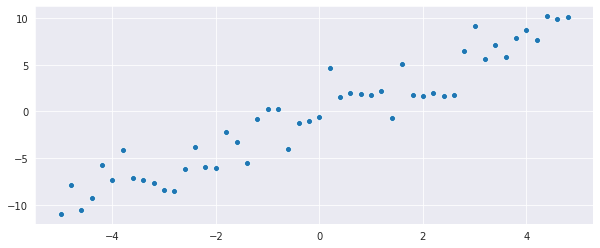

In [2]:
def generate_data():
    x_tensor = torch.arange(-5, 5, 0.2)
    y = []
    for x in x_tensor:
        noise = pyro.sample("noise", dist.Normal(torch.tensor(0.), torch.tensor(2)))
        y.append(2. * x + .3 + noise)
    y_tensor = torch.stack(y)
    return x_tensor, y_tensor

# generated data
fig, ax = plt.subplots(figsize=figsize)
x, y = generate_data()
sns.scatterplot(x, y)

In [3]:
def br_model(x, y):
    
    w = pyro.sample("w", dist.Normal(0., 1.))
    b = pyro.sample("b", dist.Normal(0., 1.))
    
    y_hat = w * x + b
    sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
    
    with pyro.plate("data", len(x)):    
        y = pyro.sample("y", dist.Normal(y_hat, sigma), obs=y)
        
kernel = NUTS(br_model)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=200)
mcmc.run(x,y)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 300/300 [00:05, 54.22it/s, step size=6.23e-01, acc. prob=0.928]


[Text(0, 0.5, 'y'), Text(0.5, 0, 'x')]

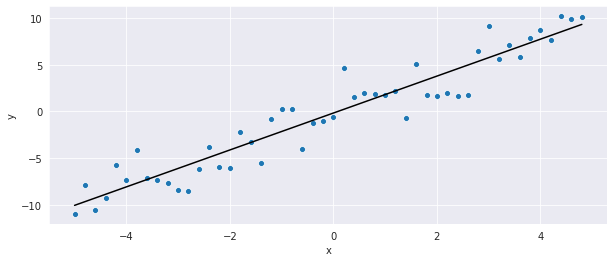

In [4]:
# extract posterior estimates
w = posterior_samples["w"].mean()
b = posterior_samples["b"].mean()
sigma = posterior_samples["sigma"].mean()

# plot regression fit
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(x, y)
sns.lineplot(x, w * x + b , color="k")
ax.set(xlabel="x", ylabel="y")
del x,y

## Multiple linear regression



In [3]:
data = pd.read_csv('data/weatherAUS.csv').dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 5939 to 139112
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cl

In [4]:
sydney_data = data.loc[data["Location"]=="Sydney"]
mlr_data = sydney_data[["Rainfall","MinTemp","MaxTemp","Humidity9am",
                        "Humidity3pm","Cloud9am","Cloud3pm"]][:100].dropna()
print("number of observations =", len(mlr_data))
mlr_data.head()

number of observations = 100


,Rainfall,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm
30487,0.2,12.9,20.3,70.0,57.0,3.0,1.0
30488,0.0,13.3,21.5,75.0,58.0,2.0,5.0
30489,0.0,15.3,23.0,70.0,63.0,1.0,4.0
30493,0.2,12.9,26.7,73.0,56.0,1.0,5.0
30494,0.0,14.8,23.8,76.0,69.0,2.0,7.0




$$
\text{Rainfall}=w_0\cdot\text{MinTemp}+w_1\cdot\text{MaxTemp}+w_2\cdot\text{Humidity9am}+\\
w_3\cdot\text{Humidity3pm}+w_4\cdot\text{Cloud9am}+w_5\cdot\text{Cloud3pm}+b
$$

In [10]:
# converting dataset columns to torch tensors
rain = torch.tensor(sydney_data["Rainfall"].values)
predictors = [torch.tensor(sydney_data[column].values) 
                           for column in ["MinTemp","MaxTemp","Humidity9am",
                                         "Humidity3pm","Cloud9am","Cloud3pm"]]

In [8]:
# modelling rain in terms of the predictors
def sydney_mlr_model(rain, predictors):
    
    # sample weights
    yhat = 0.
    for i, predictor in enumerate(predictors):
        w = pyro.sample(f"w_{i}", dist.Normal(0.,1.))
        yhat += w * predictor
    b = pyro.sample("b", dist.Normal(0.,1.))
    yhat += b
    
    # condition on the observations
    sigma = pyro.sample("sigma", dist.Normal(0.,0.5))
    with pyro.plate("data", len(rain)):
        y = pyro.sample("y", dist.Normal(yhat, sigma), obs=rain)

In [9]:
kernel = NUTS(sydney_mlr_model)
mcmc = MCMC(kernel, num_samples=50, warmup_steps=100)
mcmc.run(rain, predictors)

Sample: 100%|██████████| 150/150 [01:14,  2.01it/s, step size=6.23e-02, acc. prob=0.937]


In [10]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       w_0      0.56      0.28      0.54      0.10      0.91     16.47      1.20
       w_1     -0.75      0.25     -0.74     -1.21     -0.45     17.76      1.11
       w_2      0.21      0.06      0.21      0.13      0.31      9.18      1.28
       w_3     -0.10      0.08     -0.11     -0.17      0.09     10.47      1.20
       w_4      0.38      0.34      0.44     -0.12      0.84     37.92      1.02
       w_5      0.47      0.39      0.49     -0.09      1.10     38.53      1.02
         b     -0.02      0.83      0.18     -1.72      1.16     23.35      1.10
     sigma      5.97      0.19      5.96      5.65      6.19    148.52      0.99

Number of divergences: 0


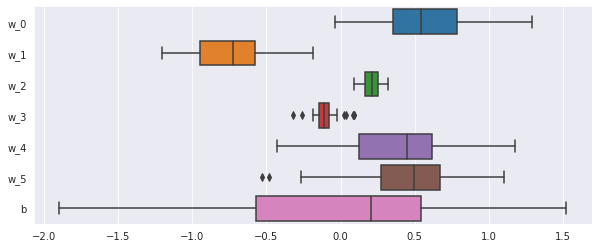

In [11]:
fig, ax = plt.subplots(figsize=figsize)
posterior_samples_df = pd.DataFrame.from_dict(mcmc.get_samples()).iloc[:,0:7]
ax = sns.boxplot(data=posterior_samples_df, orient="h")

In [12]:
# alternative equivalent model
predictors_stacked = torch.stack(predictors,1)
print(predictors_stacked.shape)

torch.Size([100, 6])


In [14]:
def sydney_mlr_model_2(rain, predictors):
    n_predictors = len(predictors[1])
    
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors),torch.ones(n_predictors)))
    b = pyro.sample("b", dist.Normal(0.,1.))
    yhat = (w*predictors).sum(dim=1) + b
    sigma = pyro.sample("sigma", dist.Normal(0.,0.5))
    
    with pyro.plate("data", len(rain)):
        y = pyro.sample("y", dist.Normal(yhat, sigma), obs=rain)

kernel = NUTS(sydney_mlr_model_2)
mcmc = MCMC(kernel, num_samples=50, warmup_steps=100)
mcmc.run(rain, predictors_stacked)

Sample: 100%|██████████| 150/150 [00:40,  3.67it/s, step size=5.65e-02, acc. prob=0.932]


In [15]:
print(mcmc.get_samples().keys())
mcmc.summary()

dict_keys(['w', 'b', 'sigma'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]      0.36      0.31      0.31     -0.12      0.77     42.21      1.04
      w[1]     -0.60      0.22     -0.58     -0.94     -0.27     24.21      1.05
      w[2]      0.17      0.06      0.17      0.08      0.25     29.31      0.98
      w[3]     -0.06      0.07     -0.07     -0.14      0.06     37.75      0.98
      w[4]      0.52      0.29      0.52      0.05      0.99     30.41      0.99
      w[5]      0.37      0.26      0.34     -0.04      0.72     34.23      1.05
         b     -0.04      0.99     -0.10     -1.72      1.55     21.79      1.06
     sigma      6.05      0.20      6.04      5.77      6.41     34.52      0.98

Number of divergences: 0


## Logistic regression



In [63]:
sydney_data = data.loc[data["Location"]=="Sydney"]
print(sydney_data["RainTomorrow"].unique(), end=" ---> ")
sydney_data['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)
print(sydney_data["RainTomorrow"].unique())

['No' 'Yes'] ---> [0 1]


/home/ginevracoal/.local/lib/python3.6/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [69]:
log_reg_data = sydney_data[["Rainfall","Humidity3pm","Cloud3pm","WindSpeed3pm",
                            "Evaporation","Pressure3pm","RainTomorrow"]]

# choose predictors and normalize data
df = log_reg_data[["Rainfall","Humidity3pm","Cloud3pm","WindSpeed3pm",
                   "Evaporation","Pressure3pm"]]
df = (df-df.min())/(df.max()-df.min())
features = torch.stack([torch.tensor(df[colname].values) for colname in df], dim=1)

# labels we want to predict
labels = torch.tensor(log_reg_data["RainTomorrow"].values, dtype=torch.double)

# train-test split
k = int(0.8 * len(log_reg_data))
x_train, y_train = features[:k], labels[:k]
x_test, y_test = features[k:], labels[k:]

print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)

x_train.shape = torch.Size([1352, 6]) 
y_train.shape = torch.Size([1352])


In [70]:
def log_reg_model(x, y):
    n_predictors = len(x[1])
    
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors),torch.ones(n_predictors)))
    b = pyro.sample("b", dist.Normal(0.,1.))
    
    # non-linearity
    yhat = torch.sigmoid((w*x).sum(dim=1) + b)
    
    with pyro.plate("data", len(x)):
        # sampling 0-1 labels from Bernoulli distribution
        y = pyro.sample("y", dist.Bernoulli(yhat), obs=y)

kernel = NUTS(log_reg_model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=200)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 300/300 [00:12, 24.77it/s, step size=1.20e-01, acc. prob=0.933]


In [72]:
w = mcmc.get_samples()["w"].mean(0)
b = mcmc.get_samples()["b"].mean()

def predict_class(x):
    out = torch.sigmoid((w * x).sum(dim=1) + b)
    return (out>0.5)

correct_predictions = (predict_class(x_test) == y_test).sum().item()
print(f"test accuracy = {correct_predictions/len(x_test)*100:.2f}%")

test accuracy = 82.25%
